In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import nltk
import re

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()

print("Fecthing data..................................")
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
newsgroups_data_all = newsgroups_train.data + newsgroups_test.data
newsgroups_labels_all = list(newsgroups_train.target) + list(newsgroups_test.target)

print("Data fetched successfully")
newsgroups_data = []
newsgroups_labels = []
for index in range(len(newsgroups_data_all)):
    newsgroups_data.append(newsgroups_data_all[index])
    newsgroups_labels.append(newsgroups_labels_all[index])
print("Sample Data :")

text = ' '.join(newsgroups_data).lower()
text[100:350]

Fecthing data..................................
Data fetched successfully
Sample Data :


'umd.edu\norganization: university of maryland, college park\nlines: 15\n\n i was wondering if anyone out there could enlighten me on this car i saw\nthe other day. it was a 2-door sports car, looked to be from the late 60s/\nearly 70s. it was called a bric'

In [3]:
sentences_text = nltk.sent_tokenize(text)
sentences = [nltk.word_tokenize(s) for s in sentences_text]
temp_sentences = []
for sentence in sentences:
    temp_words = []
    for word in sentence:
        temp_word = re.sub('[^A-Za-z]+', '', word)
        if temp_word != '':
            temp_words.append(temp_word)
    temp_sentences.append(temp_words)

sentences = temp_sentences
print(sentences[10])

['please', 'send', 'a', 'brief', 'message', 'detailing', 'your', 'experiences', 'with', 'the', 'procedure']


In [4]:
from collections import Counter
words = []
for sentence in sentences:
    words += sentence

In [5]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000


def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

In [7]:
import collections
data, count, dictionary, reverse_dictionary = build_dataset(
    words, vocabulary_size)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:10])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 149109], ('the', 240769), ('to', 120380), ('of', 113904), ('a', 105398), ('and', 95234), ('i', 84221), ('in', 80484), ('is', 71803), ('that', 65004)]
Sample data [14, 28530, 4064, 133, 17, 41, 221, 31, 39, 255] ['from', 'lerxst', 'wamumdedu', 'where', 's', 'my', 'thing', 'subject', 'what', 'car']


In [8]:
# Step 3: Function to generate a training batch for the skip-gram model.
import random
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  if data_index + span > vocabulary_size:
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

In [9]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])


28530 lerxst -> 14 from
28530 lerxst -> 4064 wamumdedu
4064 wamumdedu -> 28530 lerxst
4064 wamumdedu -> 133 where
133 where -> 4064 wamumdedu
133 where -> 17 s
17 s -> 41 my
17 s -> 133 where


In [10]:
batch_size = 128
embedding_size = 300  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)


In [21]:

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity_temp = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
  saver = tf.train.Saver()


In [12]:
from six.moves import xrange
# Step 5: Begin training.
num_steps = 100001
vec = []
with tf.Session(graph=graph) as session:

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val


    if step % 2000 == 0:
        if step > 0:
            average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
        print('Average loss at step ', step, ': ', average_loss)
        average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()
  for embd in final_embeddings:
        vec.append(embd)
    
  
    
#   try:
#   # pylint: disable=g-import-not-at-top
#     from sklearn.manifold import TSNE
#     import matplotlib.pyplot as plt

#     tsne = TSNE(
#         perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
#     plot_only = 500
#     low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
#     labels = [reverse_dictionary[i] for i in xrange(plot_only)]
#     plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

#   except ImportError as ex:
#     print('Please install sklearn, matplotlib, and scipy to show embeddings.')
#     print(ex)


Initialized
Average loss at step  0 :  302.44024658203125
Nearest to but: purdue, watson, starburstumdedu, gunpowder, hajj, imj, leicester, eradicate,
Nearest to which: conspicuous, pride, governmentfunded, doshasmmap, outperformed, dgt, pubpubinfra, mmk,
Nearest to did: considerations, olunacak, ashkar, electro, cheapen, kingsrequest, voices, universityphysics,
Nearest to so: grieve, generality, tracked, mdi, dependant, sasanid, thomasp, iteration,
Nearest to an: bailout, playoff, marcus, dependtarget, tasking, sant, espionage, az,
Nearest to who: doss, proponents, sections, symbolism, xdefaults, complient, dialinslipntsuciedu, xditview,
Nearest to of: amsterdam, moral, virvir, spydercrdgecom, conflicting, cn, jjjjj, compilers,
Nearest to by: logged, greats, hernlem, slacvmslacstanfordedu, wurman, bzzzt, lipid, adriana,
Nearest to subject: mideastforum, hib, raveling, superscalar, resistors, danny, sboxes, nuggets,
Nearest to my: stusoft, psr, pipsqueak, foolin, kljbhjkn, buyout, fsln

Average loss at step  52000 :  3.0132168940231203
Average loss at step  54000 :  3.287376358252019
Average loss at step  56000 :  4.237860122886486
Average loss at step  58000 :  2.880107008598745
Average loss at step  60000 :  2.5994468382820486
Nearest to but: ax, purdue, intriguing, cooling, makes, intend, rathole, listen,
Nearest to which: ax, mmk, secret, collecting, delaware, the, hardtofind, reconcile,
Nearest to did: ax, s, hewlettpackard, welcome, most, captaincy, prismgatechedu, oscillator,
Nearest to so: kgb, ax, halkannarbormius, mdi, a, radius, racially, hard,
Nearest to an: ax, taubensee, nothing, yellow, carried, rather, qld, handguns,
Nearest to who: ax, i, objects, beliefs, supporting, markz, rational, thus,
Nearest to of: ax, a, the, in, shaky, nusccnussg, is, armed,
Nearest to by: ax, massachvsetts, days, rather, recovered, rodrigues, nonmuslims, host,
Nearest to subject: ax, resistors, distant, parts, bill, menlo, preparation, astrophysical,
Nearest to my: ax, pcs, 

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
vec = np.array(vec)
similarity = cosine_similarity(vec)

In [37]:
test_word = "that"
test_index = dictionary[test_word]
for index in similarity[test_index].argsort()[::-1][:len(similarity)][:20]:
    print(reverse_dictionary[index])

that
ax
the
it
muratoff
in
this
you
of
righthanded
use
contact
have
i
going
not
boiler
get
destroyed
if


Initialized
Average loss at step  0 :  281.79742431640625
Nearest to but: hfe, vinlai, beginner, ensuring, wrapper, socrates, universes, ctp,
Nearest to which: desydeutsches, orgasms, testagrossa, clavazzi, manny, mailers, ems, exug,
Nearest to did: bard, nominally, secondclass, fasten, imam, kidneys, applicant, tiggerisiedu,
Nearest to so: kangaroo, gentleman, neb, traer, viable, assemblies, minimise, avoidnn,
Nearest to an: wgwaiicom, gets, prejudicial, mischief, maino, joes, keating, unknowingly,
Nearest to who: specialixcom, indeterminate, mazz, cgkarras, clumsy, mdsegticom, immaterial, cescript,
Nearest to of: size, chirps, ts, buyers, ctronnewsctroncom, visualcom, xcmapo, mdididididididididididididididi,
Nearest to by: pal, notions, dea, nlv, aberacuk, niftp, developers, programming,
Nearest to subject: ohmite, dwd, throwers, merkle, discharged, textbooks, howabout, mays,
Nearest to my: onetimepad, nasamsfc, yoo, gbp, nci, lutheran, homi, watt,
Nearest to you: durham, siemensnixd

Average loss at step  52000 :  3.193403787720017
Average loss at step  54000 :  2.9633499433845283
Average loss at step  56000 :  3.204136872433126
Average loss at step  58000 :  3.128061300976202
Average loss at step  60000 :  3.2011885138042273
Nearest to but: ax, cassettes, offer, team, combined, buy, conducts, unhappy,
Nearest to which: ax, york, expressing, slqfbql, images, houston, bicycling, pure,
Nearest to did: ax, talkpoliticsguns, fully, secondclass, applicable, rapacity, furthermore, vaxwinonamsusedu,
Nearest to so: ax, a, cruising, last, baseball, hst, thread, not,
Nearest to an: ax, gets, fpv, midnight, ottomans, shadow, xx, the,
Nearest to who: ax, a, abad, wvo, cspittedu, n, told, needed,
Nearest to of: ax, examples, UNK, require, a, ridiculously, celica, gassed,
Nearest to by: ax, iu, problem, to, legally, today, accepted, developers,
Nearest to subject: ax, roth, hour, desonia, fuzzy, serdar, jack, cap,
Nearest to my: ax, a, the, pay, contents, situations, heel, invad

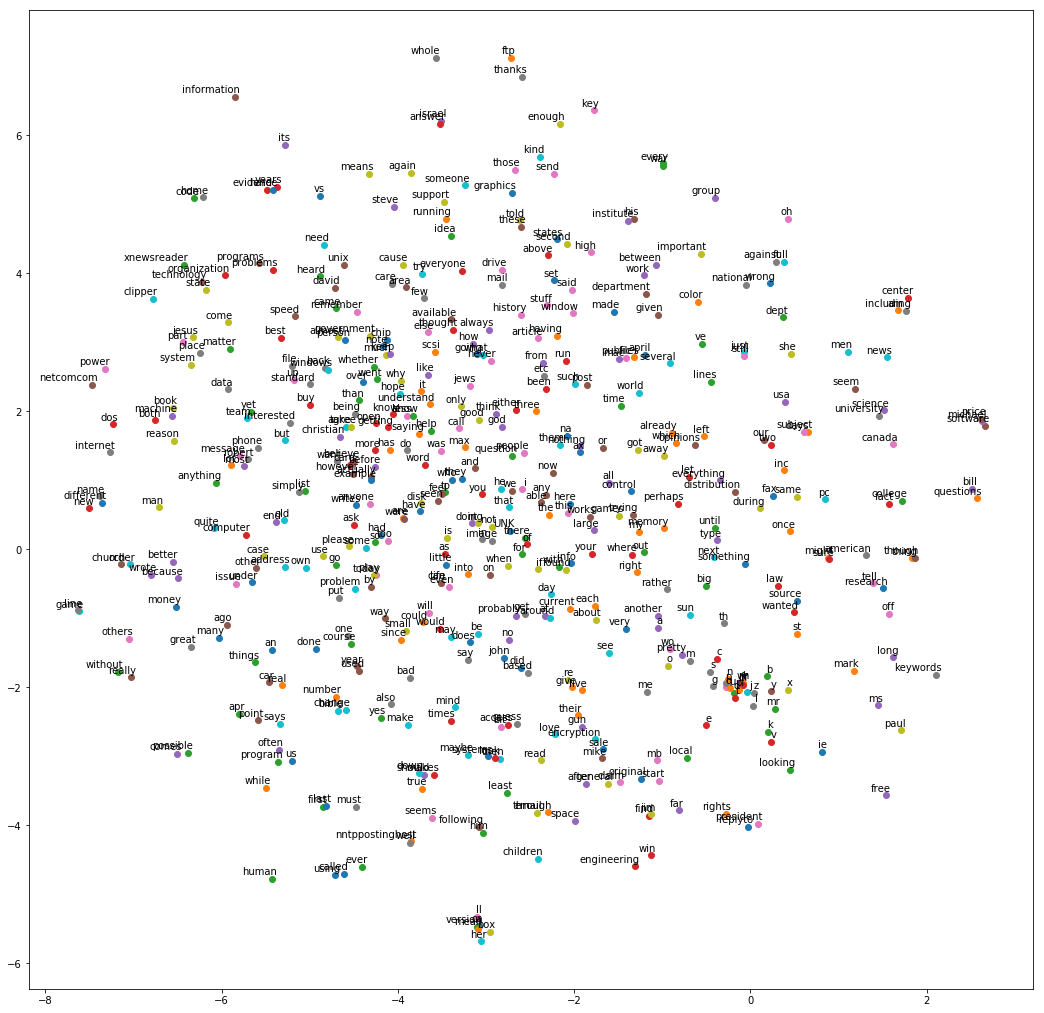

In [28]:
import os
from six.moves import xrange
# Step 5: Begin training.
num_steps = 100001
with tf.Session(graph=graph) as session:

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val


    if step % 2000 == 0:
        if step > 0:
            average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
        print('Average loss at step ', step, ': ', average_loss)
        average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity_temp.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()
    
  
  def plot_with_labels(low_dim_embs, labels, filename):
        assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
        plt.figure(figsize=(18, 18))  # in inches
        
        for i, label in enumerate(labels):
            x, y = low_dim_embs[i, :]
            plt.scatter(x, y)
            plt.annotate(
                label,
                xy=(x, y),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')

        plt.savefig(filename)

  try:
  # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(
        perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(".", 'tsne.png'))

  except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)



In [ ]:
import os
from six.moves import xrange
# Step 5: Begin training.
num_steps = 1000001
with tf.Session(graph=graph) as session:

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val


    if step % 2000 == 0:
        if step > 0:
            average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
        print('Average loss at step ', step, ': ', average_loss)
        average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity_temp.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()
    
  
  def plot_with_labels(low_dim_embs, labels, filename):
        assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
        plt.figure(figsize=(18, 18))  # in inches
        
        for i, label in enumerate(labels):
            x, y = low_dim_embs[i, :]
            plt.scatter(x, y)
            plt.annotate(
                label,
                xy=(x, y),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')

        plt.savefig(filename)

  try:
  # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(
        perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(".", 'tsne2.png'))

  except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)




Initialized
Average loss at step  0 :  283.119873046875
Nearest to but: posture, origen, strangest, tbs, trintexuucp, xtinction, birtday, pco,
Nearest to which: commonwealth, paw, skulle, ncramer, stq, jack, maintaining, ftpncsauiucedu,
Nearest to did: userspecified, madvlsicolumbiaedu, princeton, oriental, rtfmmitedu, deuterocanonical, atrocities, treatable,
Nearest to so: woke, qjbn, translators, death, radical, odea, nick, csualbertaca,
Nearest to an: ravi, headline, passage, vds, tjo, danj, spoils, calories,
Nearest to who: cunningham, extraordinaire, eden, bachlercnasagov, cfc, manipulations, fringes, phased,
Nearest to of: macrecorder, shipyards, hydraulic, postresurrection, hubucsbedu, miraculously, captaincy, lda,
Nearest to by: payment, visitors, fission, theologian, urology, faking, laserdisc, piss,
Nearest to subject: renegades, pearson, dies, puppet, pegged, bday, uiatmaatmosuiucedu, kultigin,
Nearest to my: caricature, compelling, adolfo, ussr, mixer, prognosis, cui, devnu

Average loss at step  52000 :  2.756125135080889
Average loss at step  54000 :  2.957689599520527
Average loss at step  56000 :  2.867629191823304
Average loss at step  58000 :  3.139755328133702
Average loss at step  60000 :  3.063141371525824
Nearest to but: ax, northacpubdukeedu, as, cub, era, ports, train, decline,
Nearest to which: ax, commonwealth, degrees, aged, jack, walterbellcorecom, general, mos,
Nearest to did: ax, care, atrocities, would, recall, princeton, automatically, q,
Nearest to so: woke, death, ax, supra, appeared, spot, shoved, unnecessary,
Nearest to an: ax, danj, interested, arden, aspects, tshirts, i, cooperation,
Nearest to who: ax, murmurs, i, claiming, implementation, made, pinched, default,
Nearest to of: ax, a, jpl, edsv, is, UNK, in, fellow,
Nearest to by: ax, theologian, newswire, housekeeping, utilize, q, life, centre,
Nearest to subject: ax, cute, stac, comdex, furthermore, oracle, branham, uunet,
Nearest to my: ax, vh, signal, a, machine, systematical

Average loss at step  112000 :  3.186856046076864
Average loss at step  114000 :  2.488919636653736
Average loss at step  116000 :  2.9532718696333466
Average loss at step  118000 :  3.504802589736879
Average loss at step  120000 :  3.1274198108222335
Nearest to but: ax, a, train, northacpubdukeedu, the, as, cub, decline,
Nearest to which: ax, walterbellcorecom, aged, degrees, UNK, objectives, citizenship, it,
Nearest to did: ax, would, care, atrocities, recall, until, keeps, automatically,
Nearest to so: ax, woke, death, the, a, all, appeared, spot,
Nearest to an: ax, interested, danj, tshirts, the, a, aspects, i,
Nearest to who: ax, i, murmurs, count, implementation, we, claiming, to,
Nearest to of: ax, a, the, in, r, is, UNK, jpl,
Nearest to by: ax, theologian, newswire, housekeeping, utilize, centre, formed, cellular,
Nearest to subject: ax, cute, branham, binoculars, stac, oracle, meeting, uunet,
Nearest to my: ax, a, the, vh, out, you, jimf, s,
Nearest to you: ax, i, he, UNK, the

Average loss at step  182000 :  2.686166401721537
Average loss at step  184000 :  3.0432585105746983
Average loss at step  186000 :  2.4828867204636333
Average loss at step  188000 :  2.9678162894509734
Average loss at step  190000 :  2.958654428461567
Nearest to but: ax, there, a, train, be, when, northacpubdukeedu, as,
Nearest to which: ax, objectives, this, it, citizenship, walterbellcorecom, macintosh, ouch,
Nearest to did: ax, would, care, recall, until, does, do, is,
Nearest to so: ax, death, woke, all, appeared, think, money, combat,
Nearest to an: ax, the, interested, tshirts, i, a, danj, sdsu,
Nearest to who: ax, i, count, we, implementation, that, you, murmurs,
Nearest to of: ax, in, a, i, to, is, do, the,
Nearest to by: ax, newswire, theologian, housekeeping, utilize, formed, of, definately,
Nearest to subject: ax, cute, related, savage, branham, binoculars, next, uunet,
Nearest to my: ax, a, the, you, jimf, out, is, s,
Nearest to you: ax, i, they, nt, he, we, the, it,
Neare

Average loss at step  252000 :  2.92721591534093
Average loss at step  254000 :  2.7075076372139155
Average loss at step  256000 :  4.871305704556406
Average loss at step  258000 :  2.8440754009112714
Average loss at step  260000 :  2.5542832813486456
Nearest to but: there, ax, a, of, when, train, the, in,
Nearest to which: objectives, it, ax, macintosh, not, that, mass, this,
Nearest to did: would, ax, UNK, does, care, recall, can, is,
Nearest to so: death, woke, all, ax, a, think, if, nt,
Nearest to an: ax, tshirts, any, interested, i, a, use, all,
Nearest to who: i, the, count, nt, we, he, ax, that,
Nearest to of: ax, UNK, that, is, a, in, do, the,
Nearest to by: ax, newswire, theologian, housekeeping, on, bring, for, in,
Nearest to subject: related, cute, binoculars, next, ax, uunet, savage, meeting,
Nearest to my: the, a, your, out, is, s, ax, i,
Nearest to you: i, ax, he, the, they, we, that, there,
Nearest to could: would, do, ll, ax, can, know, will, um,
Nearest to at: um, a, r

Average loss at step  322000 :  2.4993398811854424
Average loss at step  324000 :  2.9987885101698337
Average loss at step  326000 :  2.6329099506512286
Average loss at step  328000 :  2.6228184972405435
Average loss at step  330000 :  2.548728879356757
Nearest to but: ax, there, a, when, the, UNK, if, of,
Nearest to which: ax, objectives, the, not, macintosh, automatically, supposed, this,
Nearest to did: ax, would, does, can, recall, care, daughter, do,
Nearest to so: ax, death, nt, if, woke, think, money, all,
Nearest to an: ax, interested, tshirts, any, a, this, state, sdsu,
Nearest to who: ax, nt, i, we, count, turkey, that, implementation,
Nearest to of: ax, the, in, a, and, is, do, to,
Nearest to by: ax, newswire, a, housekeeping, theologian, of, bring, in,
Nearest to subject: ax, related, next, binoculars, a, cute, branham, uunet,
Nearest to my: ax, the, a, s, bf, your, out, jimf,
Nearest to you: ax, i, we, they, he, nt, it, is,
Nearest to could: ax, do, would, ll, can, will, k